In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=d231aa59eee256e10f3b0aa9d0f6fab1355b447b56104987a319f3cd13d84bb2
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StructType, StructField, IntegerType, LongType, StringType, DoubleType
from pyspark.ml.feature import Tokenizer, CountVectorizer, StringIndexer, RegexTokenizer
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import col, count, when, isnan, avg, udf
from pyspark.sql.functions import lit, array, explode, split, regexp_extract
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
# Start Spark session
spark = SparkSession.builder.appName("MovieLens").getOrCreate()

# Define the schema for the ratings DataFrame
ratings_schema = StructType([
    StructField("UserID", IntegerType(), True),
    StructField("MovieID", IntegerType(), True),
    StructField("Rating", IntegerType(), True),
    StructField("Timestamp", LongType(), True)
])

# Define the schema for the users DataFrame
users_schema = StructType([
    StructField("UserID", IntegerType(), True),
    StructField("Gender", StringType(), True),
    StructField("Age", IntegerType(), True),
    StructField("Occupation", StringType(), True),
    StructField("Zip-code", StringType(), True)
])

# Define the schema for the movies DataFrame
movies_schema = StructType([
    StructField("MovieID", IntegerType(), True),
    StructField("Title", StringType(), True),
    StructField("Genres", StringType(), True)
])

# Define file paths
ratings_file = "/content/drive/My Drive/IDS561_Project/MovieLensData/ratings.dat"
users_file = "/content/drive/My Drive/IDS561_Project/MovieLensData/users.dat"
movies_file = "/content/drive/My Drive/IDS561_Project/MovieLensData/movies.dat"

# Read the ratings file with the defined schema
ratings_df = spark.read.csv(ratings_file, sep="::", schema=ratings_schema)
users_df = spark.read.csv(users_file, sep="::", schema=users_schema)
movies_df = spark.read.csv(movies_file, sep="::", schema=movies_schema)

# Show the dataframes
ratings_df.show()
users_df.show()
movies_df.show()

+------+-------+------+---------+
|UserID|MovieID|Rating|Timestamp|
+------+-------+------+---------+
|     1|   1193|     5|978300760|
|     1|    661|     3|978302109|
|     1|    914|     3|978301968|
|     1|   3408|     4|978300275|
|     1|   2355|     5|978824291|
|     1|   1197|     3|978302268|
|     1|   1287|     5|978302039|
|     1|   2804|     5|978300719|
|     1|    594|     4|978302268|
|     1|    919|     4|978301368|
|     1|    595|     5|978824268|
|     1|    938|     4|978301752|
|     1|   2398|     4|978302281|
|     1|   2918|     4|978302124|
|     1|   1035|     5|978301753|
|     1|   2791|     4|978302188|
|     1|   2687|     3|978824268|
|     1|   2018|     4|978301777|
|     1|   3105|     5|978301713|
|     1|   2797|     4|978302039|
+------+-------+------+---------+
only showing top 20 rows

+------+------+---+----------+--------+
|UserID|Gender|Age|Occupation|Zip-code|
+------+------+---+----------+--------+
|     1|     F|  1|        10|   48067

# Cleaning and Splitting

In [ ]:
# Function to calculate and print the percentage of missing values for each column in a DataFrame
def missing_values_percentage(df, df_name):
    total_rows = df.count()
    missing_percentage = df.select([(count(when(col(c).isNull(), c)) / total_rows).alias(c) for c in df.columns]).toPandas()
    print(f"Missing Value Percentages in {df_name}:\n{missing_percentage * 100}")

# Clean and analyze the ratings DataFrame
ratings_df = ratings_df.dropDuplicates()
missing_values_percentage(ratings_df, "Ratings")

# Clean and analyze the users DataFrame
users_df = users_df.dropDuplicates()
missing_values_percentage(users_df, "Users")

# Clean and analyze the movies DataFrame
movies_file = movies_df.dropDuplicates()
missing_values_percentage(movies_file, "Movies")


Missing Value Percentages in Ratings:
   UserID  MovieID  Rating  Timestamp
0     0.0      0.0     0.0        0.0
Missing Value Percentages in Users:
   UserID  Gender  Age  Occupation  Zip-code
0     0.0     0.0  0.0         0.0       0.0
Missing Value Percentages in Movies:
   MovieID  Title  Genres
0      0.0    0.0     0.0


In [ ]:
num_rows = ratings_df.count()
num_columns = len(ratings_df.columns)

num_rows_2 = users_df.count()
num_columns_2 = len(users_df.columns)

num_rows_3 = movies_file.count()
num_columns_3 = len(movies_file.columns)

print("Ratings table Number of rows, columns:", num_rows, num_columns)
print("Users table Number of rows, columns:", num_rows_2, num_columns_2)
print("Movies table Number of rows, columns:", num_rows_3, num_columns_3)

Ratings table Number of rows, columns: 1000209 4
Users table Number of rows, columns: 6040 5
Movies table Number of rows, columns: 3883 3


In [ ]:
train_data, test_data = ratings_df.randomSplit([0.8, 0.2])

# EDA

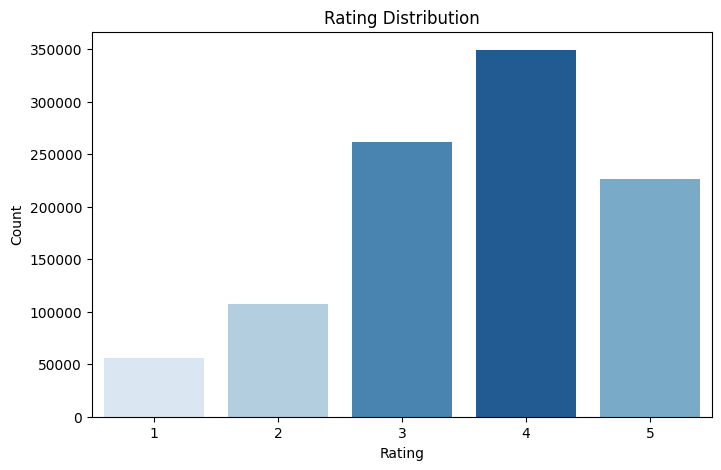

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame
ratings_pd = ratings_df.toPandas()

# Creating a blue color palette
blue_palette = sns.color_palette("Blues_r", len(ratings_pd['Rating'].unique()))

# Sorting the order and mapping colors
order = ratings_pd['Rating'].value_counts().index
palette_mapped = dict(zip(order, blue_palette))

# Plotting
plt.figure(figsize=(8, 5))
sns.countplot(data=ratings_pd, x='Rating', palette=palette_mapped)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

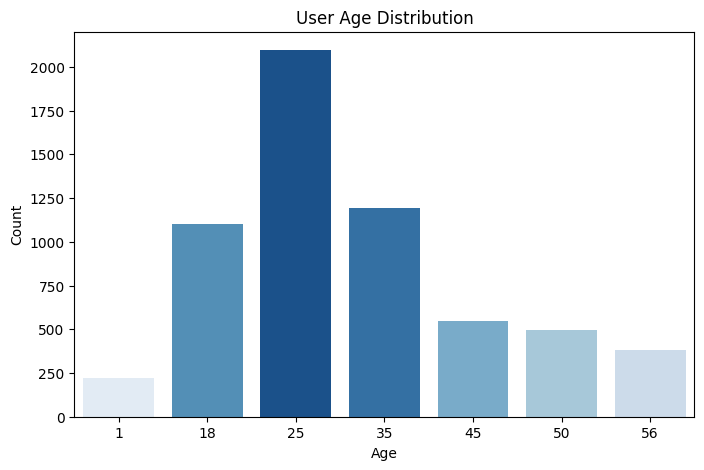

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame
users_pd = users_df.toPandas()

# Creating a blue color palette
blue_palette = sns.color_palette("Blues_r", len(users_pd['Age'].unique()))

# Sorting the order and mapping colors
order = users_pd['Age'].value_counts().index
palette_mapped = dict(zip(order, blue_palette))

# Plotting
plt.figure(figsize=(8, 5))
sns.countplot(data=users_pd, x='Age', palette=palette_mapped)
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

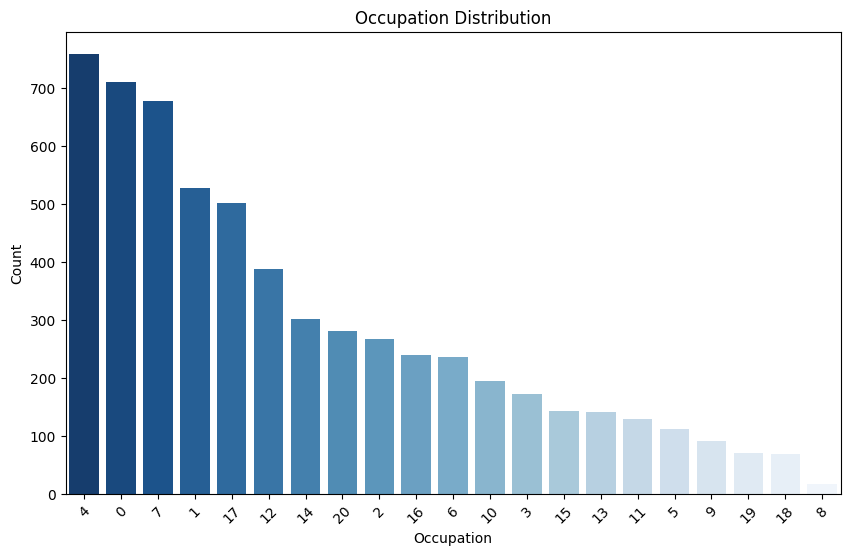

In [ ]:
# Creating a blue color palette
blue_palette = sns.color_palette("Blues_r", len(users_pd['Occupation'].unique()))

# Sorting the order and mapping colors
order = users_pd['Occupation'].value_counts().index
palette_mapped = dict(zip(order, blue_palette))

# Plotting
plt.figure(figsize=(10, 6))
sns.countplot(data=users_pd, x='Occupation', palette=palette_mapped, order=order)
plt.title('Occupation Distribution')
plt.xlabel('Occupation')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

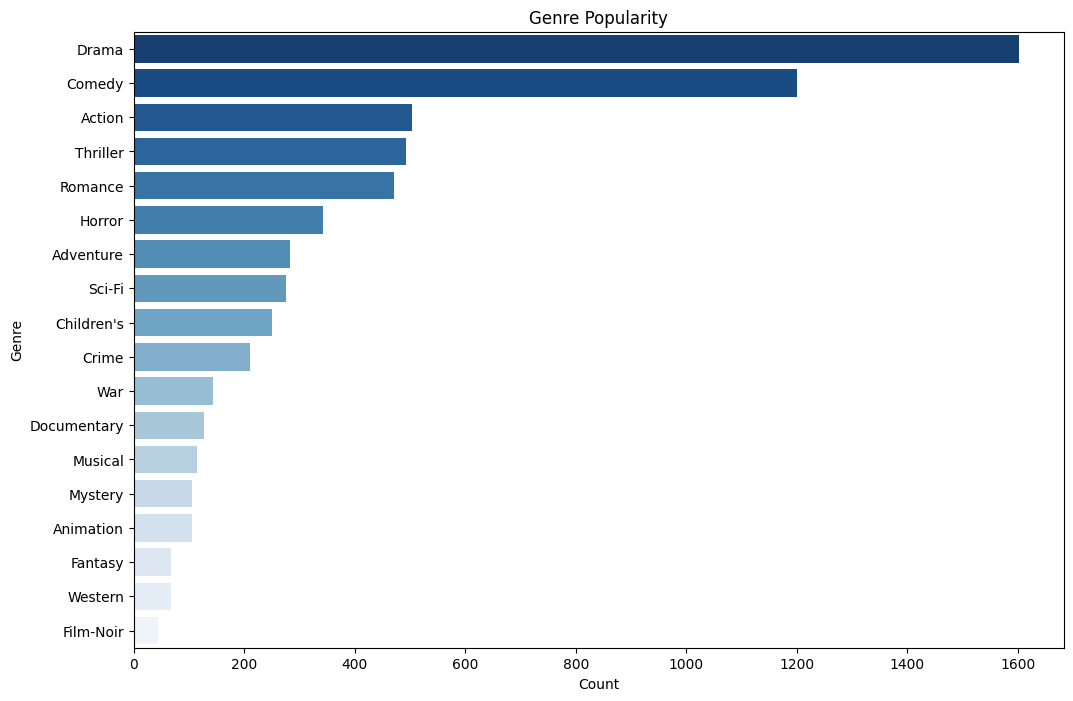

In [ ]:
# Splitting the genres and creating a new row for each genre
genre_df = movies_df.withColumn('Genre', explode(split('Genres', '\|')))

# Counting the occurrences of each genre
genre_counts = genre_df.groupBy('Genre').count().orderBy('count', ascending=False)

# Converting to Pandas DataFrame for visualization
genre_counts_pd = genre_counts.toPandas()

# Creating a blue color palette
blue_palette = sns.color_palette("Blues_r", len(genre_counts_pd['Genre']))

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(data=genre_counts_pd, x='count', y='Genre', palette=blue_palette)
plt.title('Genre Popularity')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


<ipython-input-14-6f4d5493855b>:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=movies_per_year_pd, x='Year', y='count', palette="Blues", marker='o')


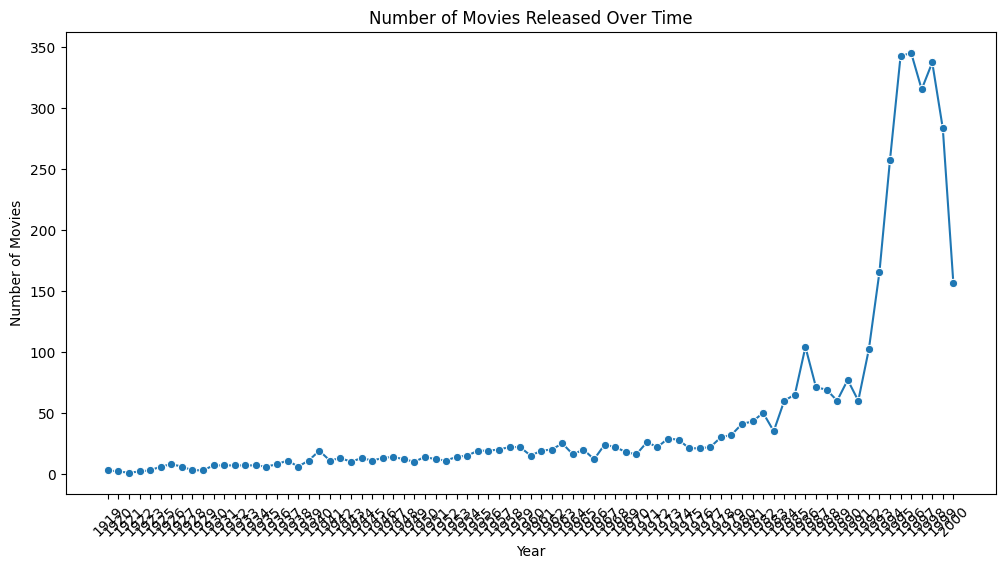

In [ ]:
# Extracting year from the title
movies_with_year = movies_df.withColumn('Year', regexp_extract('Title', '\((\d{4})\)', 1))

# Counting movies per year
movies_per_year = movies_with_year.groupBy('Year').count().orderBy('Year')

# Converting to Pandas DataFrame for visualization
movies_per_year_pd = movies_per_year.toPandas()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=movies_per_year_pd, x='Year', y='count', palette="Blues", marker='o')
plt.title('Number of Movies Released Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

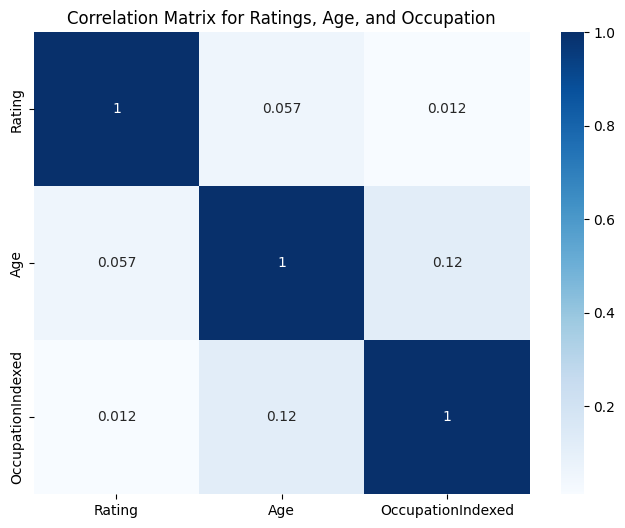

In [ ]:
# Assuming 'Occupation' is a string, we need to index it to convert to a numeric type
indexer = StringIndexer(inputCol='Occupation', outputCol='OccupationIndexed')
indexed = indexer.fit(users_df).transform(users_df)

# Now let's merge the ratings and indexed users dataframes
merged_df = ratings_df.join(indexed, 'UserID')

# Selecting only the columns we're interested in
selected_df = merged_df.select('Rating', 'Age', 'OccupationIndexed')

# Converting to Pandas DataFrame for correlation analysis
selected_pd = selected_df.toPandas()

# Ensure there are no NaN values
selected_pd = selected_pd.dropna()

# Compute the correlation matrix
corr_matrix = selected_pd.corr()

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix for Ratings, Age, and Occupation')
plt.show()


# Building Collaborative filtering

In [ ]:
als = ALS(userCol="UserID", itemCol="MovieID", ratingCol="Rating",
          rank=10, maxIter=10, regParam=0.01)

In [ ]:
model = als.fit(train_data)

In [ ]:
predictions = model.transform(test_data)
evaluator = RegressionEvaluator(metricName="mse", labelCol="Rating", predictionCol="prediction")

# Filter out rows with NaN predictions
non_nan_predictions = predictions.filter(~isnan(predictions['prediction']))

mse = evaluator.evaluate(non_nan_predictions)
print("Mean Squared Error (MSE) on test data = ", mse)

Mean Squared Error (MSE) on test data =  0.7977337085642943


Testing the Collaborative Filtering Model

In [ ]:
# Example: Inspect predictions for a specific user
user_id = 1
user_predictions = predictions.filter(predictions['UserID'] == user_id).orderBy('prediction', ascending=False)
user_predictions.show()

+------+-------+------+---------+----------+
|UserID|MovieID|Rating|Timestamp|prediction|
+------+-------+------+---------+----------+
|     1|   3408|     4|978300275| 4.8355365|
|     1|   2762|     4|978302091|  4.751011|
|     1|   1962|     4|978301753|  4.568858|
|     1|   2797|     4|978302039| 4.4694448|
|     1|    260|     4|978300760| 4.3568535|
|     1|   3114|     4|978302174|  4.307135|
|     1|   1028|     5|978301777|  4.299013|
|     1|   1197|     3|978302268| 4.2753744|
|     1|   2687|     3|978824268| 4.2006364|
|     1|   2355|     5|978824291| 3.9455776|
|     1|   2294|     4|978824291| 3.7201865|
|     1|   1022|     5|978300055| 3.6958427|
|     1|    720|     3|978300760| 3.5277057|
|     1|   1029|     5|978302205| 3.4479747|
|     1|    938|     4|978301752| 2.9518738|
+------+-------+------+---------+----------+



# Building Content Filtering

In [ ]:
regexTokenizer = RegexTokenizer(inputCol="Genres", outputCol="GenreTokens", pattern="\\|")
tokenized_movies = regexTokenizer.transform(movies_df)

# Convert the list of genres into a vector of genre counts (one-hot encoding)
vectorizer = CountVectorizer(inputCol="GenreTokens", outputCol="GenreFeatures")
model = vectorizer.fit(tokenized_movies)
vectorized_movies = model.transform(tokenized_movies)

In [ ]:
def cosine_similarity(arr1, arr2):
    vec1 = np.array(arr1)
    vec2 = np.array(arr2)
    return float(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)))

cosine_similarity_udf = udf(cosine_similarity, DoubleType())

# Add unique ID to each row
vectorized_movies = vectorized_movies.withColumn("id", monotonically_increasing_id())

vectorized_movies.select("MovieID", "Title", "GenreFeatures").show(truncate=False)


+-------+-------------------------------------+---------------------------+
|MovieID|Title                                |GenreFeatures              |
+-------+-------------------------------------+---------------------------+
|1      |Toy Story (1995)                     |(18,[1,8,14],[1.0,1.0,1.0])|
|2      |Jumanji (1995)                       |(18,[6,8,15],[1.0,1.0,1.0])|
|3      |Grumpier Old Men (1995)              |(18,[1,4],[1.0,1.0])       |
|4      |Waiting to Exhale (1995)             |(18,[0,1],[1.0,1.0])       |
|5      |Father of the Bride Part II (1995)   |(18,[1],[1.0])             |
|6      |Heat (1995)                          |(18,[2,3,9],[1.0,1.0,1.0]) |
|7      |Sabrina (1995)                       |(18,[1,4],[1.0,1.0])       |
|8      |Tom and Huck (1995)                  |(18,[6,8],[1.0,1.0])       |
|9      |Sudden Death (1995)                  |(18,[2],[1.0])             |
|10     |GoldenEye (1995)                     |(18,[2,3,6],[1.0,1.0,1.0]) |
|11     |Ame

Testing the Content Filtering Model

In [ ]:
# Select a target movie
target_movie_id = 1
target_movie_features = vectorized_movies.filter(vectorized_movies['MovieID'] == target_movie_id).select('GenreFeatures').collect()[0]['GenreFeatures']

# Convert the SparseVector to a list
target_movie_features_list = target_movie_features.toArray().tolist()

# Convert the list to a column of literal values
target_movie_features_col = array([lit(val) for val in target_movie_features_list])
vectorized_movies = vectorized_movies.withColumn("TargetMovieFeatures", target_movie_features_col)

# Calculate cosine similarity
vectorized_movies = vectorized_movies.withColumn("Similarity", cosine_similarity_udf(col("GenreFeatures"), col("TargetMovieFeatures")))

# Rank similar movies
similar_movies = vectorized_movies.select("MovieID", "Title", "Similarity").orderBy("Similarity", ascending=False)
similar_movies.show()

+-------+--------------------+------------------+
|MovieID|               Title|        Similarity|
+-------+--------------------+------------------+
|      1|    Toy Story (1995)|1.0000000000000002|
|   1064|Aladdin and the K...|1.0000000000000002|
|   2141|American Tail, An...|1.0000000000000002|
|   2142|American Tail: Fi...|1.0000000000000002|
|   2354|Rugrats Movie, Th...|1.0000000000000002|
|   2355|Bug's Life, A (1998)|1.0000000000000002|
|   3114|  Toy Story 2 (1999)|1.0000000000000002|
|   3611|Saludos Amigos (1...|1.0000000000000002|
|   3751|  Chicken Run (2000)|1.0000000000000002|
|   3754|Adventures of Roc...|1.0000000000000002|
|    239|Goofy Movie, A (1...|0.8660254037844387|
|    588|      Aladdin (1992)|0.8660254037844387|
|   2078|Jungle Book, The ...|0.8660254037844387|
|   2102|Steamboat Willie ...|0.8660254037844387|
|    881|    First Kid (1996)|0.8164965809277259|
|    250| Heavyweights (1994)|0.8164965809277259|
|    888|Land Before Time ...|0.8164965809277259|


# Building Age Filtering

In [ ]:
combined_df = ratings_df.join(users_df, "UserID").join(movies_df, "MovieID")
average_ratings_by_age_group = combined_df.groupBy("Age", "MovieID").agg(avg("Rating").alias("AverageRating"))

In [ ]:
def recommend_movies_for_age_group(age_group, num_recommendations=10):
    # Filter movies with high average ratings for the given age group
    recommended_movies = average_ratings_by_age_group.filter(average_ratings_by_age_group['Age'] == age_group).orderBy('AverageRating', ascending=False).limit(num_recommendations)
    return recommended_movies

In [ ]:
# Example: Recommend for a user in the "25-34" age group
recommendations_for_age = recommend_movies_for_age_group(25)
recommendations_for_age.show()

+---+-------+-------------+
|Age|MovieID|AverageRating|
+---+-------+-------------+
| 25|   1780|          5.0|
| 25|   3172|          5.0|
| 25|   2358|          5.0|
| 25|    853|          5.0|
| 25|   3232|          5.0|
| 25|   1795|          5.0|
| 25|   3640|          5.0|
| 25|    696|          5.0|
| 25|   1553|          5.0|
| 25|   1420|          5.0|
+---+-------+-------------+



# Building Occupation Filtering

In [ ]:
average_ratings_by_occupation = combined_df.groupBy("Occupation", "MovieID").agg(avg("Rating").alias("AverageRating"))

def occupation_based_recommendations(occupation, num_recommendations=10):
    recommended_movies = average_ratings_by_occupation.filter(average_ratings_by_occupation['Occupation'] == occupation).orderBy('AverageRating', ascending=False).limit(num_recommendations)
    return recommended_movies

In [ ]:
# Example usage
occupation_id_example = 10  # Replace with an actual occupation ID
recommended_movies_df = occupation_based_recommendations(occupation_id_example)

# Show the DataFrame
recommended_movies_df.show()

+----------+-------+-------------+
|Occupation|MovieID|AverageRating|
+----------+-------+-------------+
|        10|    117|          5.0|
|        10|   1940|          5.0|
|        10|   1131|          5.0|
|        10|   2305|          5.0|
|        10|   2929|          5.0|
|        10|   2950|          5.0|
|        10|   1836|          5.0|
|        10|   3789|          5.0|
|        10|   2630|          5.0|
|        10|    176|          5.0|
+----------+-------+-------------+



# Combining the Models

In [ ]:
def collaborative_filtering_recommendations(user_id, num_recommendations=10):
    user_predictions = predictions.filter(predictions['UserID'] == user_id).orderBy('prediction', ascending=False).limit(num_recommendations)
    return {row['MovieID']: row['prediction'] for row in user_predictions.collect()}

def get_top_rated_movies_by_user(user_id, num_movies=5):
    top_rated_movies = ratings_df.filter(ratings_df['UserID'] == user_id).orderBy('Rating', ascending=False).limit(num_movies)
    return [row['MovieID'] for row in top_rated_movies.collect()]

def content_based_recommendations(user_id, num_recommendations=10):
    top_rated_movies = get_top_rated_movies_by_user(user_id)
    recommendations = {}

    for movie_id in top_rated_movies:
        # Fetch the genre vector for the top-rated movie
        target_movie_vector = vectorized_movies.filter(vectorized_movies['MovieID'] == movie_id).select('GenreFeatures').first()['GenreFeatures']
        target_movie_vector_list = target_movie_vector.toArray().tolist()

        # Calculate similarity with other movies
        target_movie_features_col = array([lit(val) for val in target_movie_vector_list])
        temp_df = vectorized_movies.withColumn("TargetMovieFeatures", target_movie_features_col)
        temp_df = temp_df.withColumn("Similarity", cosine_similarity_udf(col("GenreFeatures"), col("TargetMovieFeatures")))

        # Get top similar movies
        similar_movies = temp_df.select("MovieID", "Similarity").orderBy("Similarity", ascending=False).limit(num_recommendations)

        for row in similar_movies.collect():
            movie_id, similarity_score = row['MovieID'], row['Similarity']
            if movie_id not in recommendations:
                recommendations[movie_id] = similarity_score

    return recommendations

def age_based_recommendations(age_group, num_recommendations=10):
    recommended_movies = average_ratings_by_age_group.filter(average_ratings_by_age_group['Age'] == age_group).orderBy('AverageRating', ascending=False).limit(num_recommendations)
    return {row['MovieID']: row['AverageRating'] for row in recommended_movies.collect()}

def occupation_based_recommendations(occupation, num_recommendations=10):
    recommended_movies = average_ratings_by_occupation.filter(average_ratings_by_occupation['Occupation'] == occupation).orderBy('AverageRating', ascending=False).limit(num_recommendations)
    return {row['MovieID']: row['AverageRating'] for row in recommended_movies.collect()}

In [ ]:
def get_user_age_group(user_id):
    user_info = users_df.filter(users_df['UserID'] == user_id).select('Age').first()
    if user_info is not None:
        return user_info['Age']
    else:
        return None

def get_user_occupation(user_id):
    user_info = users_df.filter(users_df['UserID'] == user_id).select('Occupation').first()
    if user_info is not None:
        return user_info['Occupation']
    else:
        return None

In [ ]:
def combined_recommendations(user_id, weights={'collaborative': 0.4, 'content': 0.3, 'age': 0.2, 'occupation': 0.1}, num_recommendations=10):
    # Fetch user's age group and occupation
    user_age_group = get_user_age_group(user_id)
    user_occupation = get_user_occupation(user_id)

    if user_age_group is None or user_occupation is None:
        print(f"Missing age group or occupation for UserID {user_id}")
        return []

    # Get recommendations from each model
    collaborative_recs = collaborative_filtering_recommendations(user_id)
    content_recs = content_based_recommendations(user_id)
    age_recs = age_based_recommendations(user_age_group)
    occupation_recs = occupation_based_recommendations(user_occupation)

    # Normalize the scores
    collaborative_recs = {movie: score / 5 for movie, score in collaborative_recs.items()}
    age_recs = {movie: score / 5 for movie, score in age_recs.items()}
    occupation_recs = {movie: score / 5 for movie, score in occupation_recs.items()}

    # Combine recommendations with weights
    combined_recs = {}

    for movie, score in collaborative_recs.items():
        combined_recs[movie] = combined_recs.get(movie, 0) + score * weights['collaborative']

    for movie, score in content_recs.items():
        combined_recs[movie] = combined_recs.get(movie, 0) + score * weights['content']

    for movie, score in age_recs.items():
        combined_recs[movie] = combined_recs.get(movie, 0) + score * weights['age']

    for movie, score in occupation_recs.items():
        combined_recs[movie] = combined_recs.get(movie, 0) + score * weights['occupation']

    # Sort movies based on combined score
    sorted_recs = sorted(combined_recs.items(), key=lambda x: x[1], reverse=True)

    # Return top N recommendations
    return sorted_recs[:num_recommendations]

In [ ]:
user_id_example = 1  # Replace with an actual user ID
recommended_movies = combined_recommendations(user_id_example)

rows = [Row(MovieID=movie_id, CombinedScore=score) for movie_id, score in recommended_movies]
recommendations_df = spark.createDataFrame(rows)

# Assuming 'movies_df' contains the 'MovieID' and 'Title' columns
final_recommendations_df = recommendations_df.join(movies_df,
                                                   recommendations_df.MovieID == movies_df.MovieID).select(recommendations_df.MovieID,
                                                                                                           'Title', 'CombinedScore')

# Show the DataFrame with movie titles
final_recommendations_df.show(truncate=False)

+-------+-----------------------------------------+-------------------+
|MovieID|Title                                    |CombinedScore      |
+-------+-----------------------------------------+-------------------+
|3114   |Toy Story 2 (1999)                       |0.6445708084106445 |
|2355   |Bug's Life, A (1998)                     |0.615646209716797  |
|3408   |Erin Brockovich (2000)                   |0.3868429183959961 |
|2762   |Sixth Sense, The (1999)                  |0.38008087158203124|
|1962   |Driving Miss Daisy (1989)                |0.36550865173339847|
|2797   |Big (1988)                               |0.35755558013916017|
|260    |Star Wars: Episode IV - A New Hope (1977)|0.3485482788085938 |
|1028   |Mary Poppins (1964)                      |0.34392105102539067|
|1197   |Princess Bride, The (1987)               |0.3420299530029297 |
|2687   |Tarzan (1999)                            |0.33605091094970707|
+-------+-----------------------------------------+-------------